<a href="https://colab.research.google.com/github/vithushanms/makemore-language-model/blob/main/%5BLanguage_Models%5D_makemore_MLP_Further_Optimization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [42]:
#if cloud
from google.colab import drive
drive.mount('/content/drive')
dataFilePath = '/content/drive/My Drive/Publications/Neural Networks Research/makemore: next char prediction language model/names.txt'
words = open(dataFilePath, 'r').read().splitlines() 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# encode chars in the words to integer
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [44]:
block_size = 3 

def build_dataset(words):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [45]:
C = torch.randn((27,10),requires_grad=True)
W1 = torch.randn((30,300), requires_grad=True)
b1 = torch.randn(300, requires_grad=True)
W2 = torch.randn((300, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [46]:
stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  logits = ((emb.view(-1,dimension) @ W1 + b1).tanh()) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())

In [47]:
@torch.no_grad()
def split_loss(split):
  X, Y = {
      'test' : { Xtest, Ytest },
      'dev' : { Xdev, Ydev },
      'train': { Xtr, Ytr }
  }[split]
  emb = C[X]
  out_h = (emb.view(-1, dimension) @ W1 + b1).tanh()
  logits = out_h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} : {loss.item()}')

In [48]:
split_loss('dev')
split_loss('train')

dev : 2.396000623703003
train : 2.3585641384124756


If we print all the loss in the iteration the loss starts at very high number

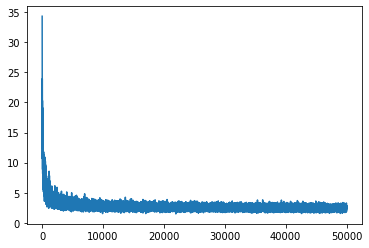

In [49]:
plt.plot(stepi, lossi)

This makes the model iterate few times unnessesarily and makes the training process more innefficent. therefore we can start from a realistic loss

since we have the 27 characters the releastic probability for the model would be somewhere close to 1/27

In [50]:
#releastic loss would be close to
-torch.tensor((1/27)).log()

tensor(3.2958)

In [81]:
#modifyin the last layer's output logits to be very close to 0, then it would probabily
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
W1 = torch.randn((n_emb*3,n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) *0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [82]:
stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)
  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())

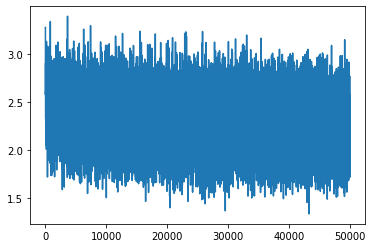

In [80]:
plt.plot(stepi, lossi)

Now if we look at the output from the hidden layers are basically passing through the tanh function. let's see the values which are coming out from this tanh activation in a histogram 

(array([2578.,  231.,  175.,  115.,  142.,  129.,  118.,  142.,  184.,
        2586.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

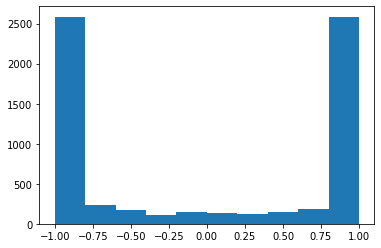

In [84]:
plt.hist(out_h.view(-1).tolist())

Since most of them are close to 1 and -1, it's not a very good sign

(array([2.000e+00, 6.000e+00, 7.300e+01, 3.650e+02, 1.131e+03, 2.229e+03,
        1.725e+03, 6.840e+02, 1.590e+02, 2.600e+01]),
 array([-26.4328022 , -21.84644413, -17.26008606, -12.67372799,
         -8.08736992,  -3.50101185,   1.08534622,   5.67170429,
         10.25806236,  14.84442043,  19.4307785 ]),
 <BarContainer object of 10 artists>)

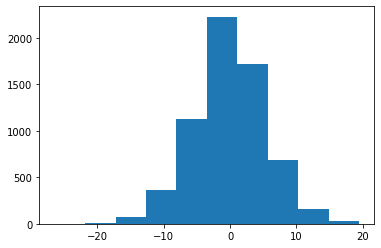

In [85]:
plt.hist(out_h_preactivation.view(-1).tolist())

The derevative of the tanh is going to be 1 - tanh**2. So, the values which are in the tails which is 1 or -1 from the outcome will be staying in very close to 0 when we backpropogate the tanh function. therefore it never gonna get activated  

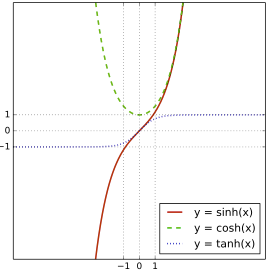

Let's analyze this with respect to our training mini batch during the last iteration

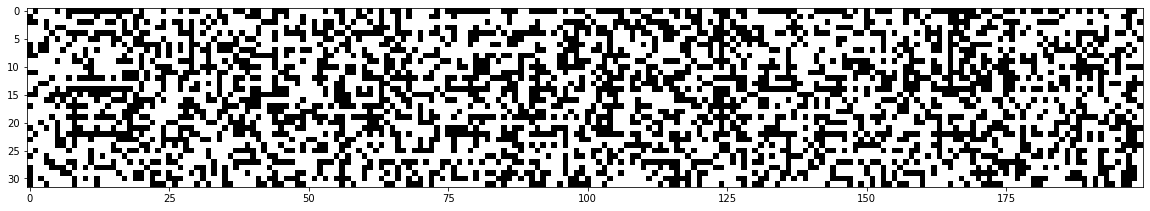

In [91]:
plt.figure(figsize=(20,10))
plt.imshow((-0.99 < out_h.abs()) & (out_h.abs() > 0.99), cmap='gray', interpolation='nearest')

#here x axis is going to be the neuron in the hidden layer
#y axis is going to be the concatinated emb values going through the neurons
#the white color boxes are going to be the ones which doesn't activate the neurons, in the other words absolute value of out_h is higher than 0.99 and falling in the flat side of tanh

There we can't see the flat all complete white boxes in any columns. which is kind of a good news 

This conncept will be applicable for other activation non linear activations such as sigmoid, tanh, relu, etc. when the value get fall into flat region of the activation function it's never gonna activbate the neurons


This issue can be fixed by tunning the initial weights and the bias of the layer to be close to zero or very small. because the out_h is coming from the contact emb after going through the weights and bias

In [95]:
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
W1 = torch.randn((n_emb*3,n_hidden)) * 0.1
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) *0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)
  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())



(array([1103.,  305.,  321.,  362., 1085., 1203.,  326.,  306.,  357.,
        1032.]),
 array([-0.99999994, -0.79999995, -0.59999996, -0.39999998, -0.19999999,
         0.        ,  0.19999999,  0.39999998,  0.59999996,  0.79999995,
         0.99999994]),
 <BarContainer object of 10 artists>)

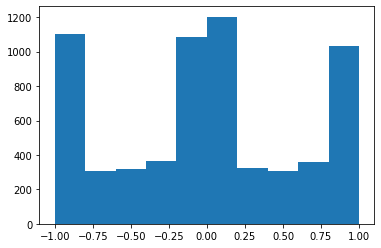

In [96]:
plt.hist(out_h.view(-1).tolist())

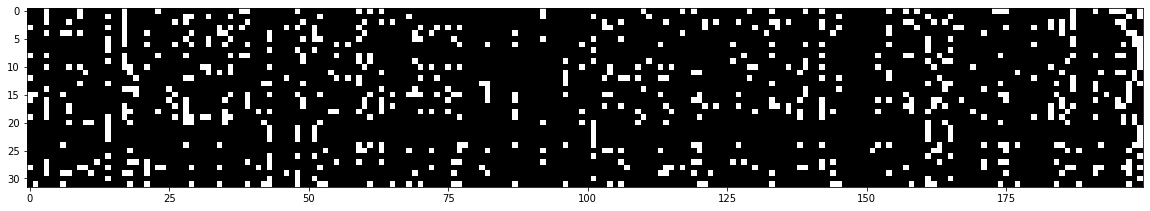

In [97]:
plt.figure(figsize=(20,10))
plt.imshow((-0.99 < out_h.abs()) & (out_h.abs() > 0.99), cmap='gray', interpolation='nearest')

In [98]:
#when we calculate the loss, now we can see the improvements
split_loss('dev')
split_loss('train')

dev : 2.215797185897827
train : 2.175738573074341


In [64]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] 
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cex.
daiomanue.
ilani.
yon.
vonichton.
crangan.
kandr.
sorivie.
jovhi.
iolai.
molivianno.
kentedo.
kaleyda.
sidz.
eniaverry.
fobs.
mollie.
bron.
love.
dodi.
